In [1]:
import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from math import radians, cos, sin, sqrt, asin

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [32]:
df_taxi = pd.read_csv('TaxiFare.csv')
df_taxi.head()

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [33]:
#unique_id is insignificant for the training of the model, so we must drop it
df_taxi.drop('unique_id', axis = 1, inplace = True)

In [34]:
df_taxi.shape

(50000, 7)

In [35]:
df_taxi.dtypes

amount                  float64
date_time_of_pickup      object
longitude_of_pickup     float64
latitude_of_pickup      float64
longitude_of_dropoff    float64
latitude_of_dropoff     float64
no_of_passenger           int64
dtype: object

In [36]:
#the date_time_of_pickup is object while it should be datetime
df_taxi.date_time_of_pickup = pd.to_datetime(df_taxi.date_time_of_pickup)

In [37]:
df_taxi.dtypes

amount                              float64
date_time_of_pickup     datetime64[ns, UTC]
longitude_of_pickup                 float64
latitude_of_pickup                  float64
longitude_of_dropoff                float64
latitude_of_dropoff                 float64
no_of_passenger                       int64
dtype: object

In [38]:
# We will extract new features from date_time_of_pickup namely hour, day, month, year, dayofweek

df_taxi = df_taxi.assign(hour = df_taxi.date_time_of_pickup.dt.hour,
                         day = df_taxi.date_time_of_pickup.dt.day,
                         month = df_taxi.date_time_of_pickup.dt.month,
                         year = df_taxi.date_time_of_pickup.dt.year,
                         weekday = df_taxi.date_time_of_pickup.dt.weekday,)
df_taxi


,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,weekday
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,15.0,2013-06-12 23:25:15+00:00,-73.999973,40.748531,-74.016899,40.705993,1,23,12,6,2013,2
49996,7.5,2015-06-22 17:19:18+00:00,-73.984756,40.768211,-73.987366,40.760597,1,17,22,6,2015,0
49997,6.9,2011-01-30 04:53:00+00:00,-74.002698,40.739428,-73.998108,40.759483,1,4,30,1,2011,6
49998,4.5,2012-11-06 07:09:00+00:00,-73.946062,40.777567,-73.953450,40.779687,2,7,6,11,2012,1


In [44]:
# We will extract new feature that measures the distance travelled from longitude and latitude. We will use Haversine formula

def distance_measure(longitude1, latitude1, longitude2, latitude2):
    travel_dist = []
    
    for pos in range(len(longitude1)):
        long1,lati1,long2,lati2 = map(radians, [longitude1[pos], latitude1[pos], longitude2[pos], latitude2[pos]])
        dist_long = long2-long1
        dist_lati = lati2-lati1
        a = sin(dist_lati/2)**2 + cos(lati1) * cos(lati2) * sin(dist_long/2)**2
        c = 2*asin(sqrt(a))*6371
        travel_dist.append(c)
    return travel_dist



In [45]:
df_taxi['distance_travelled'] = distance_measure(df_taxi['longitude_of_pickup'].to_numpy(),
                           df_taxi['latitude_of_pickup'].to_numpy(),
                           df_taxi['longitude_of_dropoff'].to_numpy(),
                           df_taxi['latitude_of_dropoff'].to_numpy())

In [46]:
df_taxi

,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,weekday,distance_travelled
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0,1.030764
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1,8.450134
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3,1.389525
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5,2.799270
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1,1.999157
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,15.0,2013-06-12 23:25:15+00:00,-73.999973,40.748531,-74.016899,40.705993,1,23,12,6,2013,2,4.940374
49996,7.5,2015-06-22 17:19:18+00:00,-73.984756,40.768211,-73.987366,40.760597,1,17,22,6,2015,0,0.874706
49997,6.9,2011-01-30 04:53:00+00:00,-74.002698,40.739428,-73.998108,40.759483,1,4,30,1,2011,6,2.263286
49998,4.5,2012-11-06 07:09:00+00:00,-73.946062,40.777567,-73.953450,40.779687,2,7,6,11,2012,1,0.665245


In [48]:
#Now we can drop date_time_of-pickup
df_taxi = df_taxi.drop('date_time_of_pickup', axis = 1)

In [49]:
df_taxi.info

<bound method DataFrame.info of        amount  longitude_of_pickup  latitude_of_pickup  longitude_of_dropoff  \
0         4.5           -73.844311           40.721319            -73.841610   
1        16.9           -74.016048           40.711303            -73.979268   
2         5.7           -73.982738           40.761270            -73.991242   
3         7.7           -73.987130           40.733143            -73.991567   
4         5.3           -73.968095           40.768008            -73.956655   
...       ...                  ...                 ...                   ...   
49995    15.0           -73.999973           40.748531            -74.016899   
49996     7.5           -73.984756           40.768211            -73.987366   
49997     6.9           -74.002698           40.739428            -73.998108   
49998     4.5           -73.946062           40.777567            -73.953450   
49999    10.9           -73.932603           40.763805            -73.932603   

       

In [50]:
#Statistical Summary of the data
df_taxi.describe()

,amount,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,weekday,distance_travelled
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840,13.489080,15.672040,6.273300,2011.739260,3.029980,18.508946
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195,6.506935,8.660789,3.461157,1.862639,1.956936,355.564309
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000,0.000000,1.000000,1.000000,2009.000000,0.000000,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000,9.000000,8.000000,3.000000,2010.000000,1.000000,1.223146
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000,14.000000,16.000000,6.000000,2012.000000,3.000000,2.120114
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000,19.000000,23.000000,9.000000,2013.000000,5.000000,3.895570
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000,23.000000,31.000000,12.000000,2015.000000,6.000000,8667.818812


In [52]:
#We will only keep the observation where fare is > 2.5 to avoid outliers
df_taxi = df_taxi.loc[(df_taxi.amount >= 2.5)]

In [53]:
df_taxi.shape

(49990, 12)

In [56]:
# We will only keep data where the distance travelled is less than 130km to avoid Outliers
df_taxi = df_taxi.loc[(df_taxi.distance_travelled >= 1) | (df_taxi.distance_travelled <=130)]

In [57]:
df_taxi.shape

(49990, 12)

In [58]:
#Remove Observations with unreal coordinates, 90<latitude<-90, 180< longitude <-180

incorrect_coordinates = (df_taxi.latitude_of_pickup>90)| (df_taxi.latitude_of_pickup<-90) | (df_taxi.latitude_of_dropoff>90) | (df_taxi.latitude_of_dropoff<-90) | (df_taxi.longitude_of_pickup > 180) | (df_taxi.longitude_of_pickup < -180) | (df_taxi.longitude_of_dropoff>180) | (df_taxi.longitude_of_dropoff<-180)

In [60]:
df_taxi.drop(incorrect_coordinates, inplace = True, errors = 'ignore')

In [61]:
df_taxi.shape

(49990, 12)

In [67]:
# Check for missing values
total = df_taxi.isnull().sum().sort_values(ascending=False)

percent = (df_taxi.isnull().sum()*100/df_taxi.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])

missing_data['Types'] = df_taxi[missing_data.index].dtypes

missing_data

,Total,Percentage of Missing Values,Types
amount,0,0.0,float64
longitude_of_pickup,0,0.0,float64
latitude_of_pickup,0,0.0,float64
longitude_of_dropoff,0,0.0,float64
latitude_of_dropoff,0,0.0,float64
no_of_passenger,0,0.0,int64
hour,0,0.0,int32
day,0,0.0,int32
month,0,0.0,int32
year,0,0.0,int32


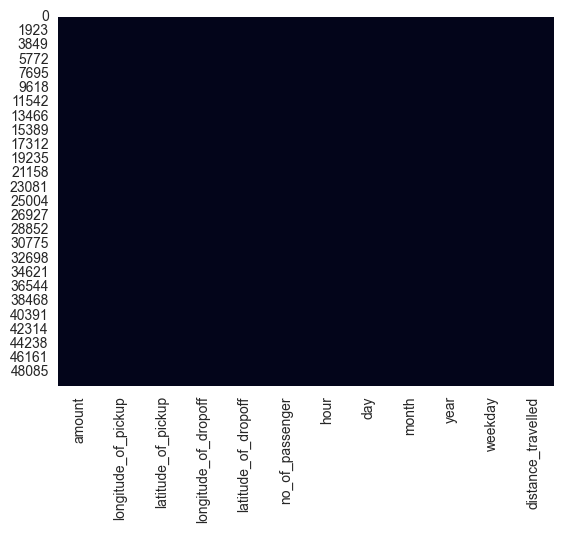

In [71]:
# Plot Heatmap to visualize the null values

sns.heatmap(df_taxi.isnull(), cbar = False)
plt.show()

In [72]:
# Generate Correlation Matrix
cor = df_taxi.corr()
cor

,amount,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,weekday,distance_travelled
amount,1.000000,0.005908,-0.007305,0.004454,-0.005603,0.016515,-0.022003,-0.001445,0.026738,0.121087,0.000525,0.016450
longitude_of_pickup,0.005908,1.000000,-0.950587,0.956613,-0.947401,-0.005612,0.004914,0.006004,0.000401,-0.001263,-0.003227,0.143712
latitude_of_pickup,-0.007305,-0.950587,1.000000,-0.911581,0.928614,0.003244,-0.004610,-0.006660,0.000725,-0.001353,0.003014,-0.126408
longitude_of_dropoff,0.004454,0.956613,-0.911581,1.000000,-0.982102,-0.004872,0.005507,0.005216,0.001322,-0.000326,-0.002444,0.143172
latitude_of_dropoff,-0.005603,-0.947401,0.928614,-0.982102,1.000000,0.002897,-0.004531,-0.008008,-0.000340,-0.001818,0.001629,-0.124844
no_of_passenger,0.016515,-0.005612,0.003244,-0.004872,0.002897,1.000000,0.011404,0.006769,0.009097,0.006389,0.038570,-0.005371
hour,-0.022003,0.004914,-0.004610,0.005507,-0.004531,0.011404,1.000000,-0.008205,-0.001917,0.004170,-0.091273,0.000643
day,-0.001445,0.006004,-0.006660,0.005216,-0.008008,0.006769,-0.008205,1.000000,-0.017258,-0.011168,0.008455,0.010611
month,0.026738,0.000401,0.000725,0.001322,-0.000340,0.009097,-0.001917,-0.017258,1.000000,-0.115728,-0.010000,-0.009217
year,0.121087,-0.001263,-0.001353,-0.000326,-0.001818,0.006389,0.004170,-0.011168,-0.115728,1.000000,0.006800,0.022135


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, 'amount'),
  Text(0, 1.5, 'longitude_of_pickup'),
  Text(0, 2.5, 'latitude_of_pickup'),
  Text(0, 3.5, 'longitude_of_dropoff'),
  Text(0, 4.5, 'latitude_of_dropoff'),
  Text(0, 5.5, 'no_of_passenger'),
  Text(0, 6.5, 'hour'),
  Text(0, 7.5, 'day'),
  Text(0, 8.5, 'month'),
  Text(0, 9.5, 'year'),
  Text(0, 10.5, 'weekday'),
  Text(0, 11.5, 'distance_travelled')])

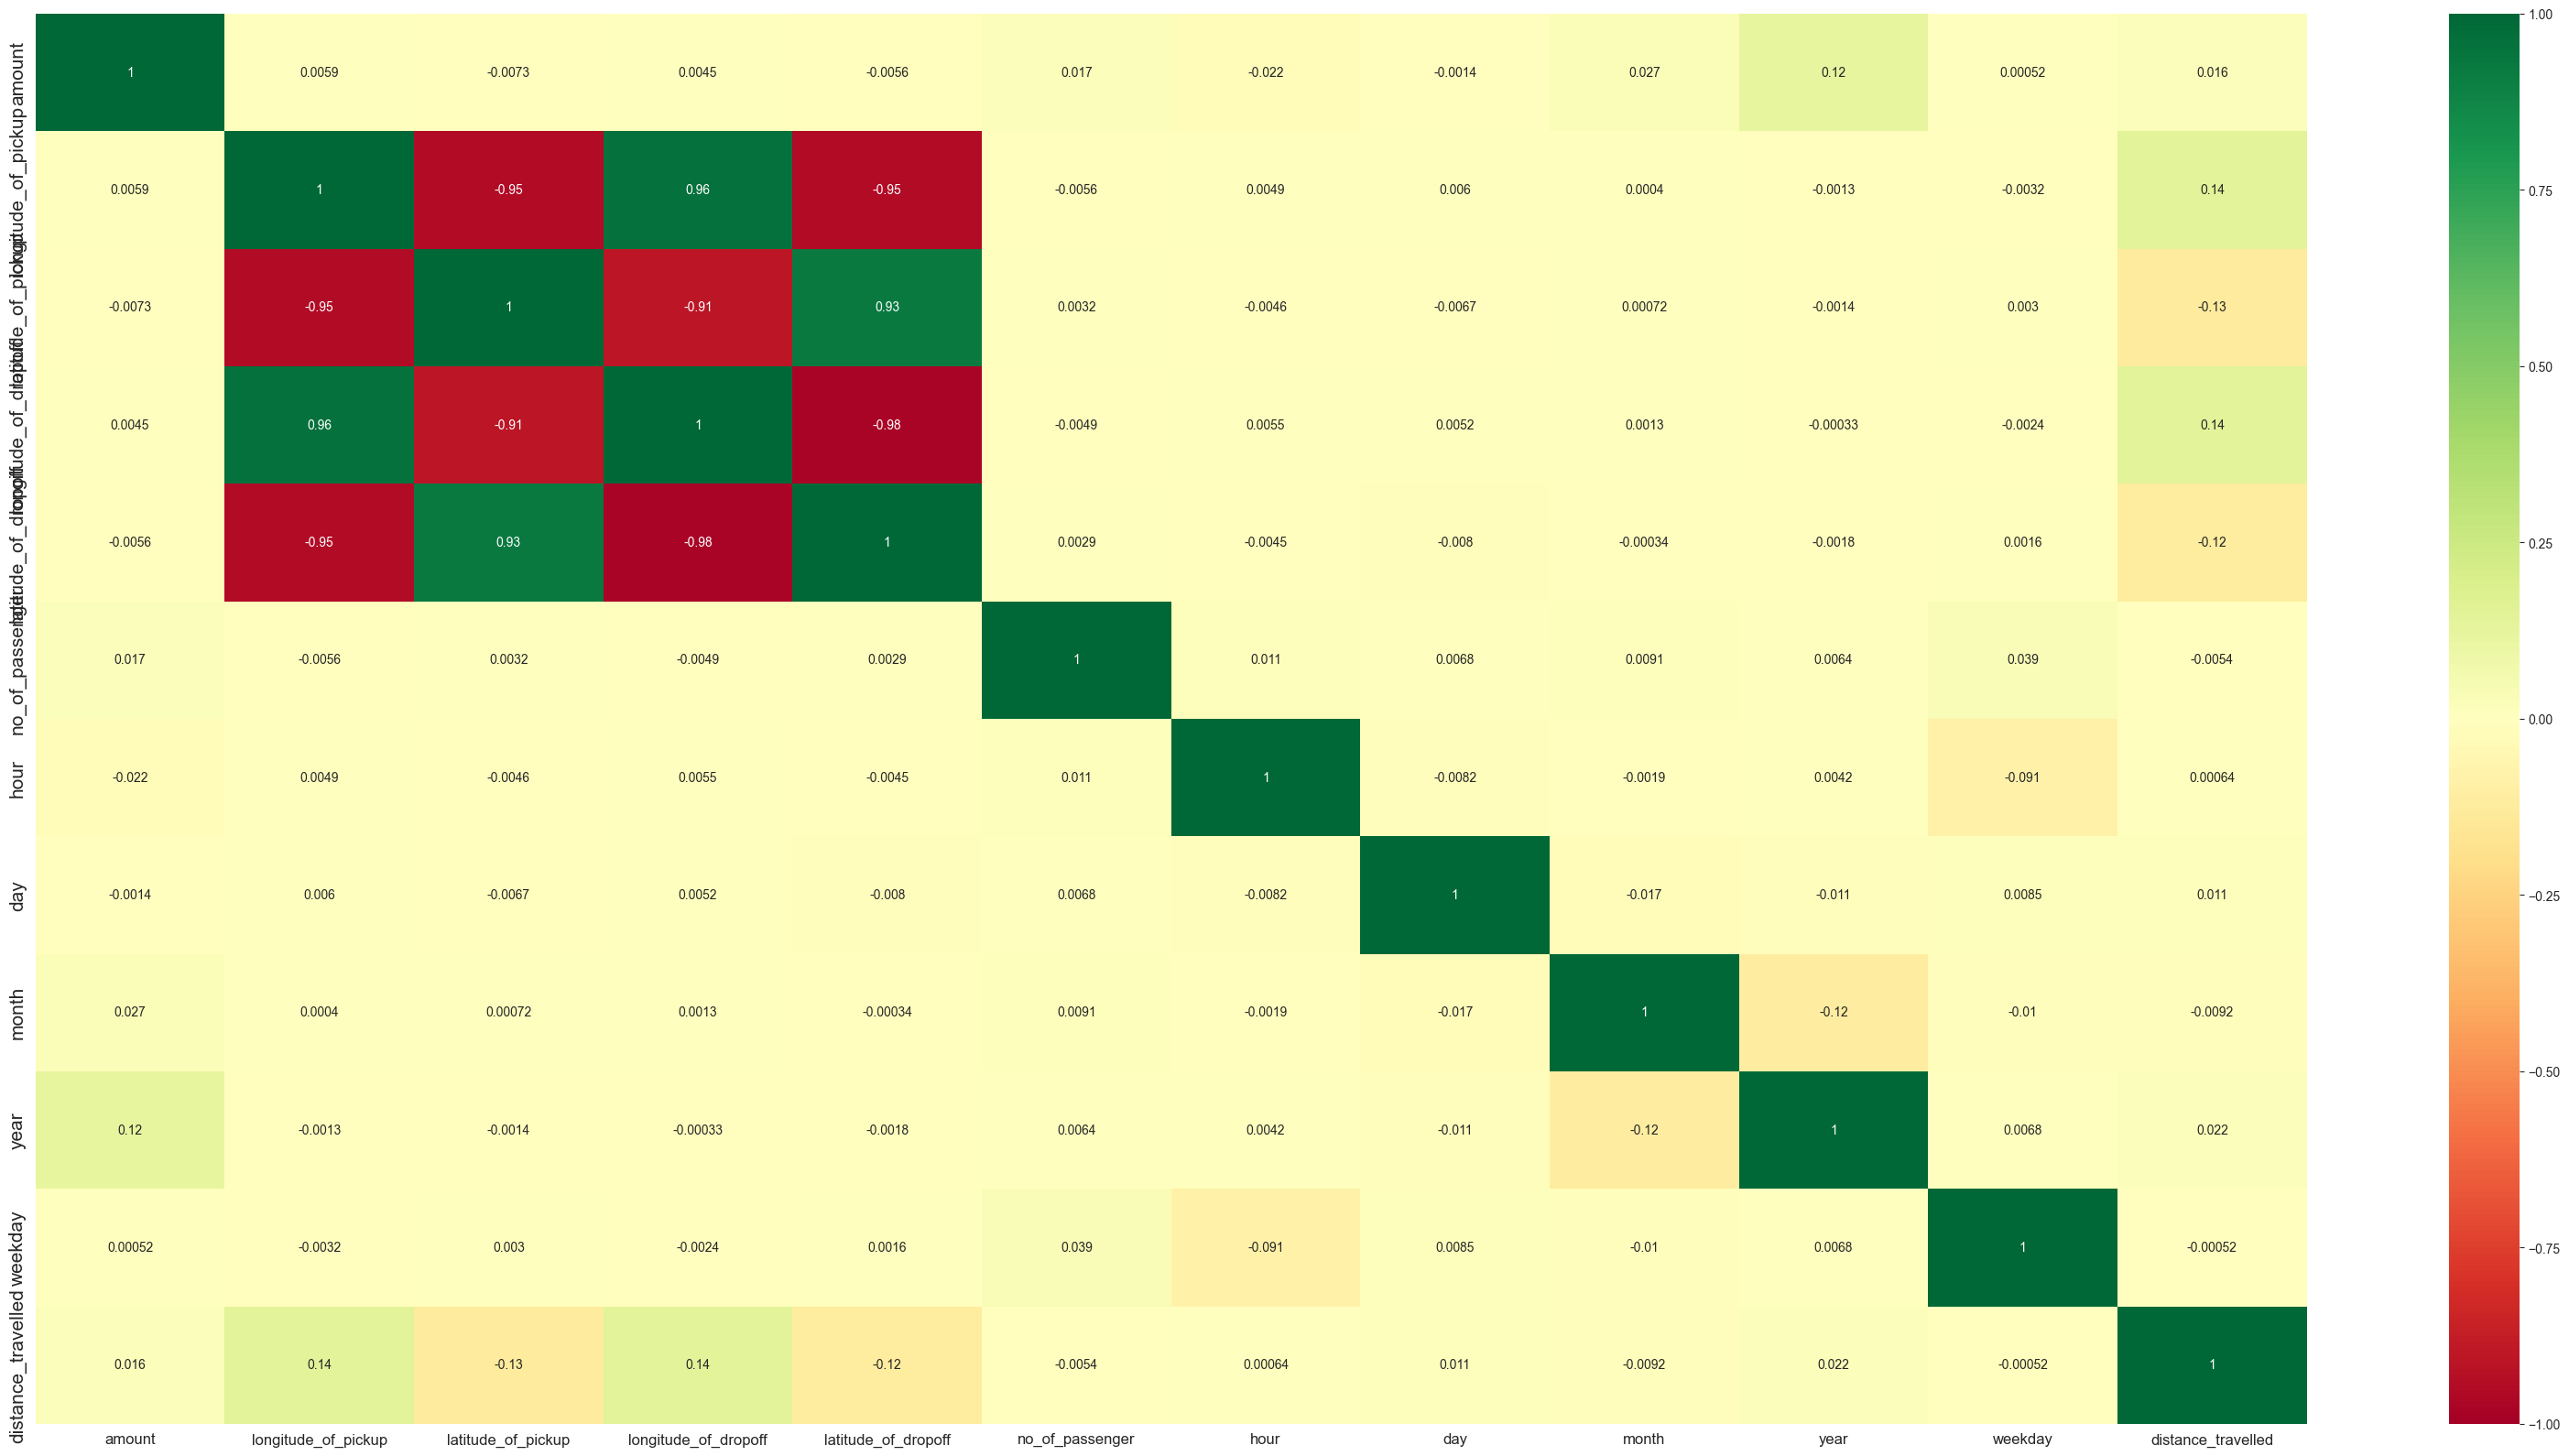

In [77]:
# Heatmap for diagonal correlation matrix
plt.figure(figsize = (40,20))
sns.heatmap(cor, cmap='RdYlGn', vmax = 1.0, vmin = -1.0, annot=True)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 15)


In [78]:
# The above plot shows that there is highest positive correlation (= 0.96) between the variables 'longitude_of_pickup' and 'longitude_of_dropoff'. Also there is strong positive correlation between the pair latitude_of_pickup and latitude_of_dropoff. These variables may be involved in multicollinearity.
# Following variable pairs have strong negative correlation in the dataset(longitude_of_pickup,latitude_of_pickup), (latitude_of_dropoff,longitude_of_pickup),(longitude_of_dropoff,latitude_of_pickup) and (longitude_of_dropoff, latitude_of_dropoff).

<Axes: title={'center': 'Taxi Trips Count During Week Days'}, xlabel='hour', ylabel='count'>

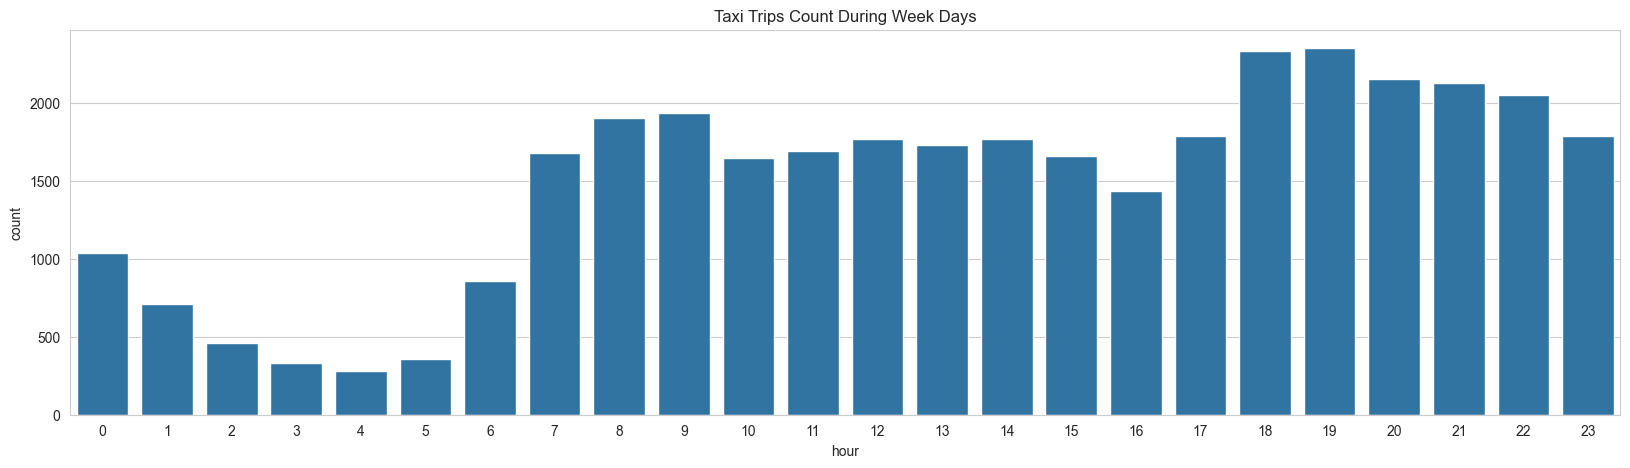

In [85]:
#Plot Countplot to check peak hours during weekdays

plt.figure(figsize = (20,5))
plt.title('Taxi Trips Count During Week Days')
sns.set_style('white')

sns.countplot(x = 'hour', data = df_taxi.loc[(df_taxi.weekday >= 0) & (df_taxi.weekday <= 4)])

<Axes: title={'center': 'Taxi Trips Count During Week ends'}, xlabel='hour', ylabel='count'>

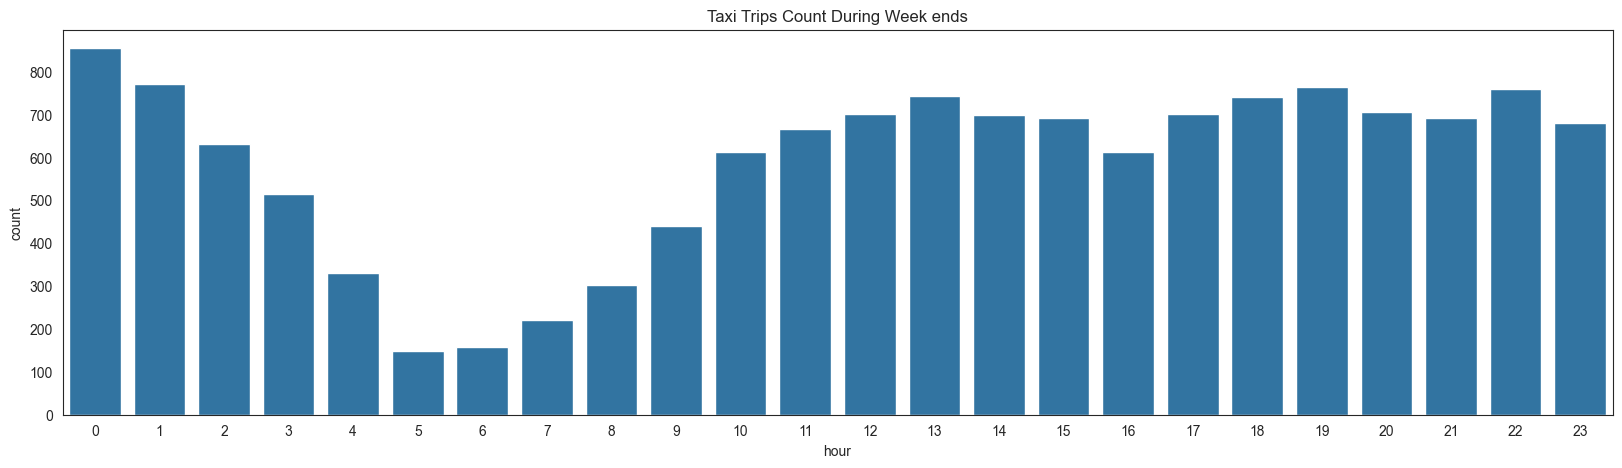

In [87]:
#Plot Countplot to check peak hours during weekends

plt.figure(figsize = (20,5))
plt.title('Taxi Trips Count During Week ends')
sns.set_style('white')

sns.countplot(x = 'hour', data = df_taxi.loc[(df_taxi.weekday >= 5) & (df_taxi.weekday <= 6)])



In [88]:
# Hourly Mean Fair for Weekdays and Weekends

week_days = df_taxi.loc[(df_taxi.weekday >= 0) & (df_taxi.weekday <= 4)]

week_ends = df_taxi.loc[(df_taxi.weekday >= 5) & (df_taxi.weekday <= 6)]

week_days_fare = week_days.groupby(['hour']).amount.mean().to_frame().reset_index()
week_ends_fare = week_ends.groupby(['hour']).amount.mean().to_frame().reset_index()

In [89]:
week_days_fare

,hour,amount
0,0,12.079275
1,1,12.522360
2,2,10.929956
3,3,11.837477
4,4,14.961357
5,5,15.502702
6,6,11.438986
7,7,10.863713
8,8,10.468992
9,9,10.699696


In [90]:
week_ends_fare

,hour,amount
0,0,11.733544
1,1,10.991658
2,2,11.476212
3,3,12.249047
4,4,12.704848
5,5,15.059730
6,6,16.821950
7,7,13.081629
8,8,11.554950
9,9,9.805147


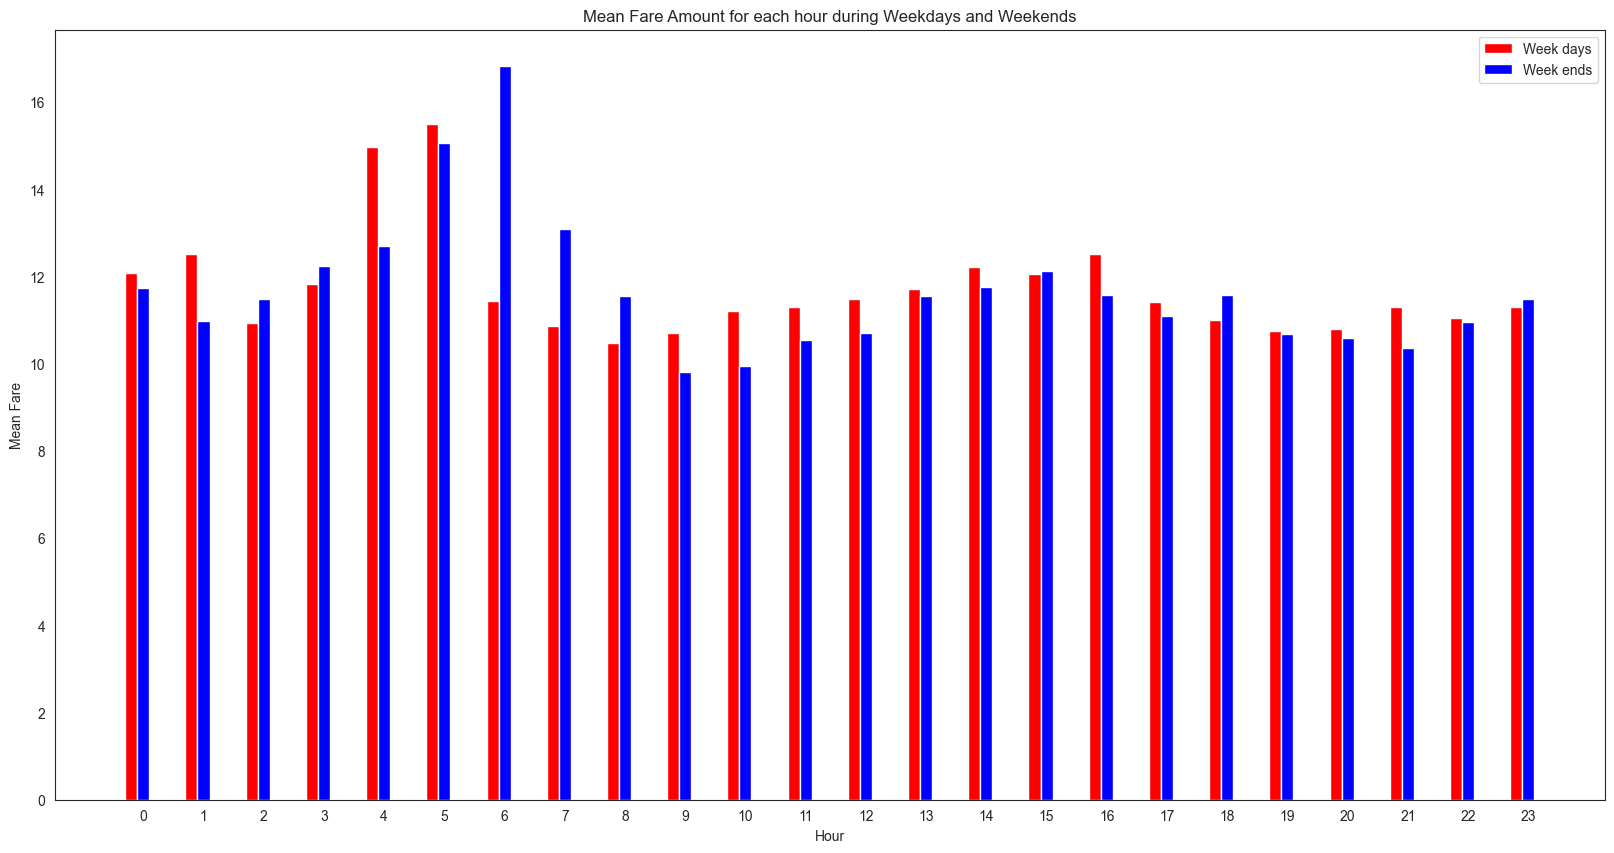

In [95]:
# Plot the mean Fare
x = np.array(week_ends_fare.hour) #hours

y = np.array(week_days_fare.amount) #fare on weekdays

z = np.array(week_ends_fare.amount) #fare on weekends

plt.figure(figsize = (20,10))
plt.title('Mean Fare Amount for each hour during Weekdays and Weekends')
plt.xlabel('Hour')
plt.ylabel('Mean Fare')

ax = plt.subplot(1,1,1)

ax.bar(x-0.2, y, width=0.2, color = 'red', align = 'center', label = 'Week days')
ax.bar(x, z, width=0.2, color = 'blue', align = 'center', label = 'Week ends')

plt.xticks(range(0,24))

plt.legend()
plt.show()


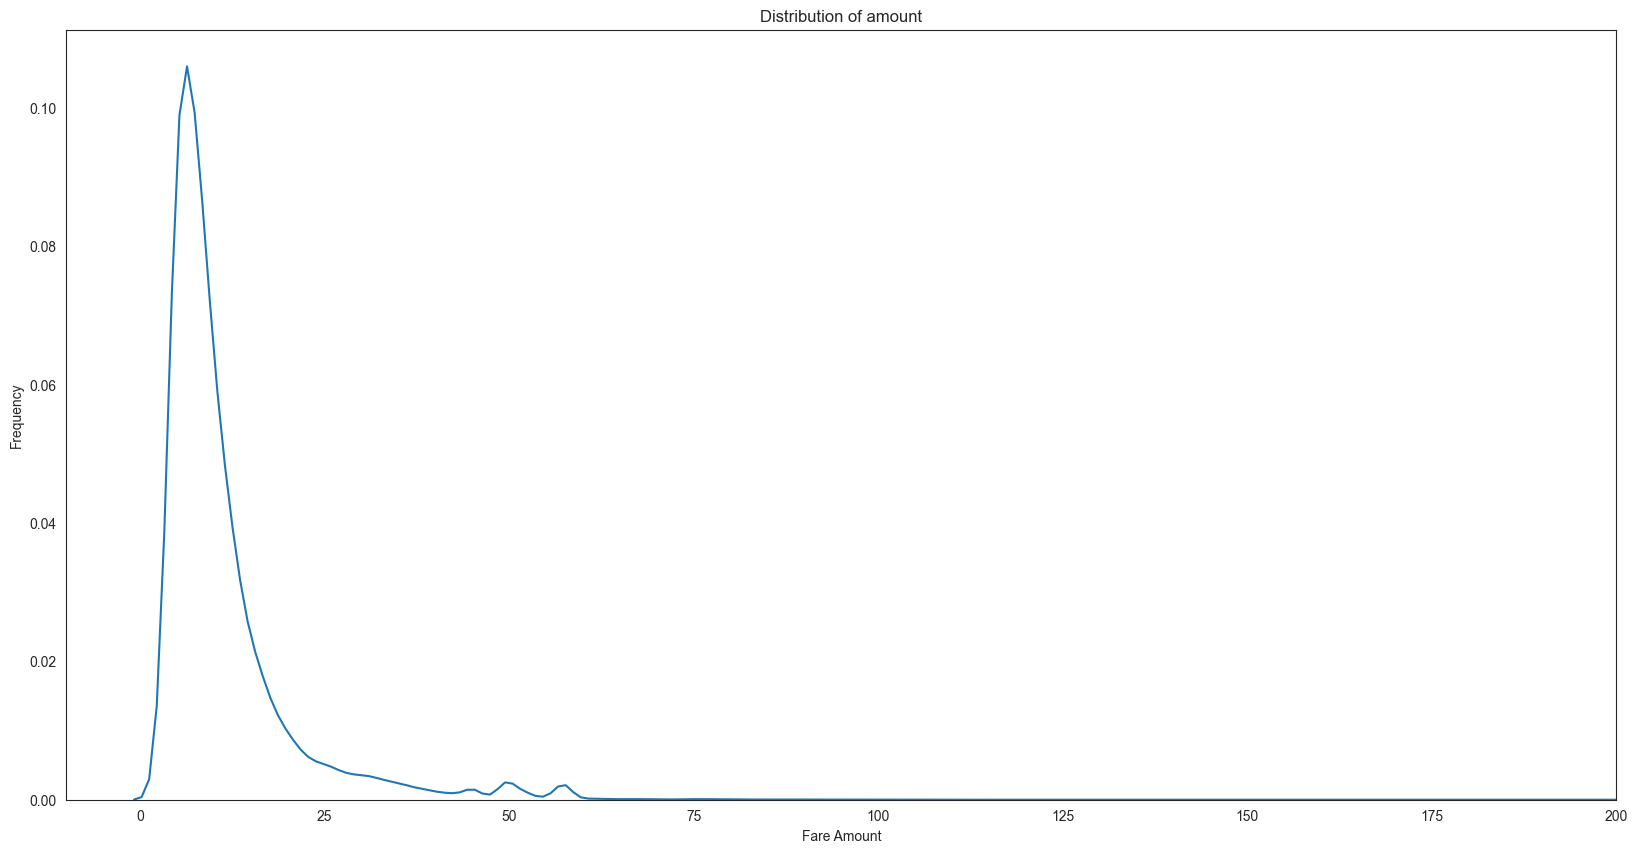

In [98]:
# Check distribution of fare 'amount'

plt.figure(figsize = (20,10))
plt.title("Distribution of amount")
plt.xlabel("Fare Amount")
plt.ylabel("Frequency")
plt.xlim(-10,200)

snsplot = sns.kdeplot(df_taxi.amount)

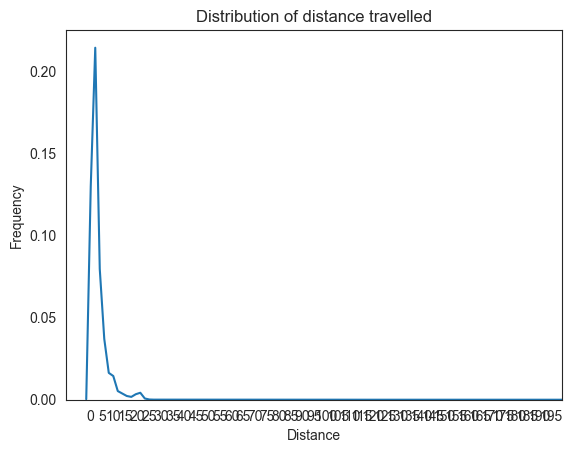

In [102]:
# Distribution of distance travelled

plt.title("Distribution of distance travelled")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.xlim(-10,200)
plt.xticks(range(0,200,5))

sns.plot = sns.kdeplot(df_taxi[df_taxi.distance_travelled<600].distance_travelled)

In [103]:
#Now we build a model using Random Forest regressor

In [104]:
#Firstly we will split the into feature amd target dataframes

y = pd.DataFrame(df_taxi['amount'])

X = df_taxi.drop('amount', axis = 1)  

In [105]:
X.head()

,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,hour,day,month,year,weekday,distance_travelled
0,-73.844311,40.721319,-73.841610,40.712278,1,17,15,6,2009,0,1.030764
1,-74.016048,40.711303,-73.979268,40.782004,1,16,5,1,2010,1,8.450134
2,-73.982738,40.761270,-73.991242,40.750562,2,0,18,8,2011,3,1.389525
3,-73.987130,40.733143,-73.991567,40.758092,1,4,21,4,2012,5,2.799270
4,-73.968095,40.768008,-73.956655,40.783762,1,7,9,3,2010,1,1.999157


In [108]:
#Now we split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

print("The shape of X_train is:",X_train.shape)
print("The shape of X_test is:",X_test.shape)
print("The shape of y_train is:",y_train.shape)
print("The shape of y_test is:",y_test.shape)

The shape of X_train is: (34993, 11)
The shape of X_test is: (14997, 11)
The shape of y_train is: (34993, 1)
The shape of y_test is: (14997, 1)


In [113]:
# BUILD MODEL USING RANDOM FOREST REGRESSOR
regressor = RandomForestRegressor(n_estimators=100, random_state=10)
regressor.fit(X_train, y_train.values.ravel())

RandomForestRegressor(random_state=10)

In [114]:
y_pred = regressor.predict(X_test)

In [136]:
# Now we calculate the accuracy measures Root-mean-square-error (RMSE), R-squared and Adjusted R-squared.

regressor_MAE = metrics.mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error = ', regressor_MAE)

regressor_MSE = metrics.mean_squared_error(y_test, y_pred)
print('Mean Squared Error = ', regressor_MSE)

regressor_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error = ', regressor_MAE)


Mean Absolute Error =  2.0364987930919516
Mean Squared Error =  18.78625911903321
Root Mean Squared Error =  2.0364987930919516


In [141]:
#Tabulate the results for comparison

cols = ['Model', 'MAE', 'MSE', 'RMSE']

result_tabulation = pd.DataFrame(columns = cols)

regressor_metrics = pd.Series({'Model': "Random Forest ",
                               'MAE': regressor_MAE,
                               'MSE': regressor_MSE,
                               'RMSE': regressor_RMSE})

# result_tabulation = result_tabulation._append(regressor_metrics, ignore_index=True)

result_tabulation = pd.concat([result_tabulation, regressor_metrics.to_frame().T], ignore_index=True)
result_tabulation

,Model,MAE,MSE,RMSE
0,Random Forest,2.036499,18.786259,4.334312


In [117]:
#Now we use cross-validation to optimize our decision tree using the GridSearchCV() from sklearn library
parameters = [{'n_estimators' : [85, 100],
               'min_samples_split' : [15,20],
               'max_depth' : [8,10]}]

In [119]:
regressor_CV = RandomForestRegressor(random_state=10)

grid = GridSearchCV(estimator = regressor_CV, param_grid= parameters, cv = 10)

dt_grid = grid.fit(X_train, y_train.values.ravel())

In [120]:
print('Best parameters set found on development set:', dt_grid.best_params_ )

Best parameters set found on development set: {'max_depth': 10, 'min_samples_split': 15, 'n_estimators': 100}


In [121]:
# PRedict values using obtained hyperparameters

In [122]:
dt_grid_model = RandomForestRegressor(n_estimators=dt_grid.best_params_.get('n_estimators'),max_depth= dt_grid.best_params_.get('max_depth'), min_samples_split= dt_grid.best_params_.get('min_samples_split'), random_state= 10)

dt_grid_model.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=10, min_samples_split=15, random_state=10)

In [123]:
#Predict using test set
y_pred_new = dt_grid_model.predict(X_test)

In [124]:
# calculate accuray measures Root-mean-square-error (RMSE), R-squared and Adjusted R-squared

regressor_CV_MAE = metrics.mean_absolute_error(y_test, y_pred_new)
regressor_CV_MSE = metrics.mean_squared_error(y_test, y_pred_new)
regressor_CV_RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred_new))
print('Mean Absolute Error = ', regressor_CV_MAE)
print('Mean Squared Error = ', regressor_CV_MSE)
print('Root Mean Squared Error = ', regressor_CV_RMSE)

Mean Absolute Error =  2.0771200042661886
Mean Squared Error =  18.903093131136636
Root Mean Squared Error =  4.347768753180951


In [144]:
regressor_metrics_new = pd.Series({'Model': "Random Forest with GridSearchCV ",
                               'MAE': regressor_CV_MAE,
                               'MSE': regressor_CV_MSE,
                               'RMSE': regressor_CV_RMSE})

# result_tabulation = result_tabulation._append(regressor_metrics, ignore_index=True)

result_tabulation = pd.concat([result_tabulation, regressor_metrics_new.to_frame().T], ignore_index=True)
result_tabulation

,Model,MAE,MSE,RMSE
0,Random Forest,2.036499,18.786259,4.334312
1,Random Forest with GridSearchCV,2.07712,18.903093,4.347769


In [ ]:
#The above result shows that the RMSE value for both the Model is much less than the standard deviation of the 'amount' (target) variable. Soth the models have performed well. We ca Further fine tune the models for various hyperparameters values.